In [1]:
import pandas as pd
import numpy as np

In [2]:
import os 
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
imgfold = os.listdir('../datasciencebowl/stage1_train/')

In [12]:
import pathlib
import imageio

In [13]:
img_path = pathlib.Path('../datasciencebowl/stage1_train/').glob('*/images/*.png')

In [14]:
img_sort = sorted([x for x in img_path])
im_path = img_sort[5]


In [72]:

im = cv2.imread(str(im_path))

In [26]:
cv2.imshow("image",im)
cv2.waitKey()
cv2.destroyAllWindows()

In [80]:
imrgb = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
imgray = cv2.cvtColor(imrgb,cv2.COLOR_RGB2GRAY)

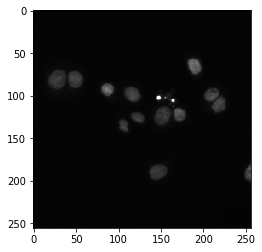

In [81]:
plt.imshow(imgray,cmap="gray")

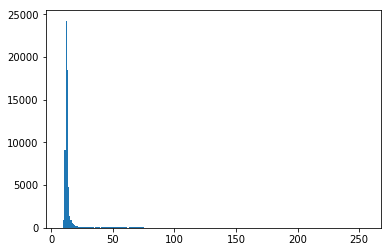

In [83]:
#plot hist
plt.hist(imgray.ravel(),256)
plt.show()

In [84]:
#plot gausiisn filtered
blur = cv2.GaussianBlur(imgray,(5,5),0)

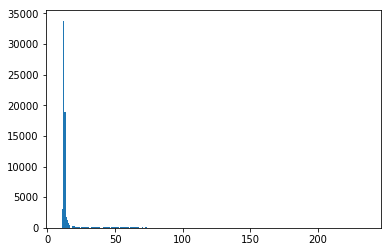

In [85]:
plt.hist(blur.ravel(),256)
plt.show()

In [87]:
#otsu
ret2,th2 = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#plt.imshow(the,cmap="gray")

In [91]:
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [86]:
ret1,th1 = cv2.threshold(imgray,127,255,cv2.THRESH_BINARY)

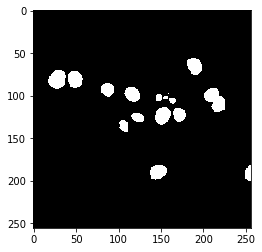

In [124]:
plt.imshow(th3,cmap="gray")

In [108]:
im_pixels = blur.flatten()
im_pixels

array([13, 13, 13, ..., 11, 11, 11], dtype=uint8)

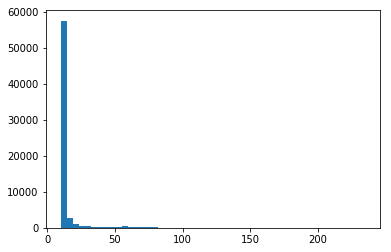

In [109]:
plt.hist(im_pixels,bins=50)
plt.show()

In [116]:
mask = np.where(th3,th3,np.NaN)

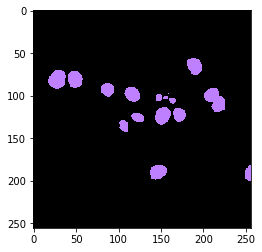

In [117]:
plt.imshow(th3,cmap = "gray")
plt.imshow(mask,cmap = "rainbow",alpha =0.5)
plt.show()

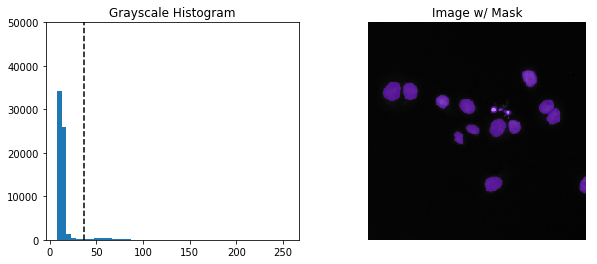

In [118]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = imgray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(ret3, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask = np.where(th3,th3,np.NaN)
plt.imshow(imgray, cmap='gray')
plt.imshow(mask, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

In [120]:
from scipy import ndimage

In [185]:
from scipy import ndimage
labels, nlabels = ndimage.label(th3)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 16 separate components / objects detected.


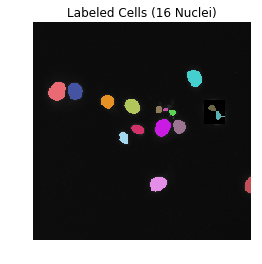

In [186]:
# Create a random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(imgray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()


In [187]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = imgray[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        th3 = np.where(labels==label_ind+1, 0, th3)

# Regenerate the labels
labels, nlabels = ndimage.label(th3)
print('There are now {} separate components / objects detected.'.format(nlabels))

There are now 16 separate components / objects detected.


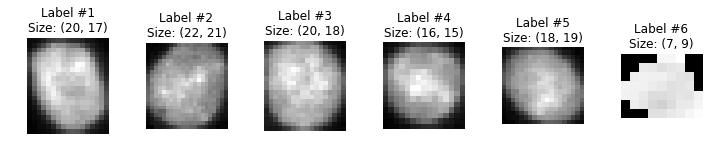

In [188]:
fig, axes = plt.subplots(1,6, figsize=(10,10))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = imgray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

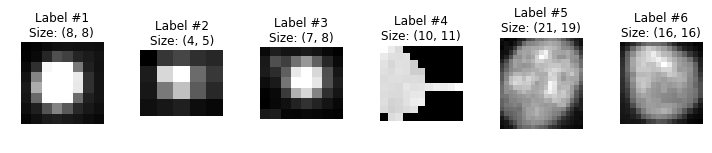

In [189]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[6:12]):
    cell = imgray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

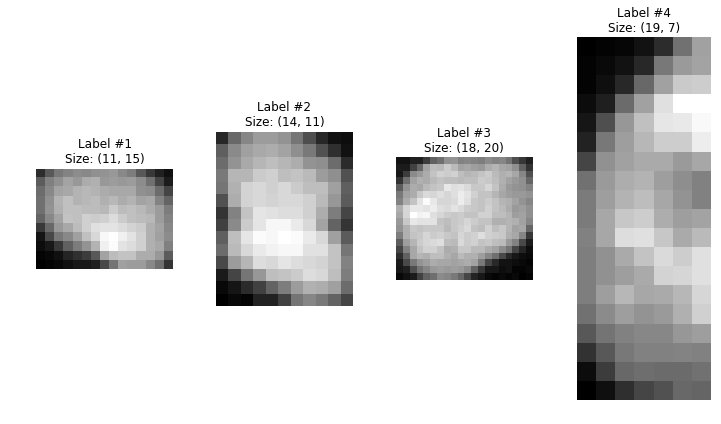

In [190]:
fig, axes = plt.subplots(1,4, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[12:16]):
    cell = imgray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

In [172]:
#as can be seen there is overlap in the nuclei
#thus performing dilation and erosion
two_cell_indices = ndimage.find_objects(labels)[5]
cell_mask = th3[two_cell_indices]
cell_mask.shape

(28, 25)

In [177]:
kernel = np.ones((5,5), np.uint8)
img_erosion = cv2.erode(cell_mask, kernel, iterations=2)

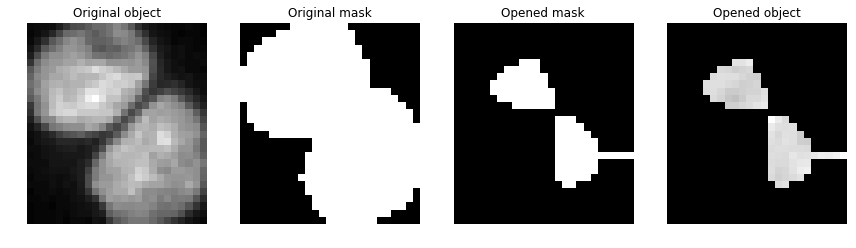

In [178]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(imgray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(th3[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(img_erosion, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(imgray[two_cell_indices]*img_erosion, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [183]:
th3[two_cell_indices] = img_erosion
imgray[two_cell_indices] = imgray[two_cell_indices]*img_erosion

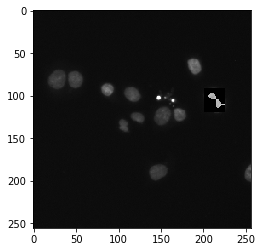

In [184]:
plt.imshow(imgray,cmap="gray")

In [196]:
maskbin = np.where(th3 == 255,1,0)

In [204]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [207]:
def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = cv2.imread(str(im_path))
    im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    # Mask out background and extract connected objects
    blur = cv2.GaussianBlur(im_gray,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #thresh_val = threshold_otsu(im_gray)
    #mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(th==0) < np.sum(th==1):
        th = np.where(th, 0, 1)    
        #labels, nlabels = ndimage.label(th)
    
    labels, nlabels = ndimage.label(th)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df

In [208]:
def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [210]:
testing = pathlib.Path('../datasciencebowl/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv', index=None)